In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import itertools

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed

import random


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# inspired by 
# https://machinelearningmastery.com/use-different-batch-sizes-training-predicting-python-keras/
# https://www.tensorflow.org/tutorials/text/text_generation

# create sequence
length = 1000
num_features = 2

# create X/y pairs

ones =  [random.random() for i in range(length)]
partial_sums = list(itertools.accumulate(ones))

sequence = [0.0] + partial_sums

d = {"x0": sequence[:-1], "x1": ones, "y": sequence[1:]}

df = pd.DataFrame(data=d)
print(df.head())
# convert to LSTM friendly format
X = df[["x0", "x1"]].to_numpy()
Y = df[["y"]].to_numpy()


         x0        x1         y
0  0.000000  0.369078  0.369078
1  0.369078  0.537373  0.906451
2  0.906451  0.570138  1.476589
3  1.476589  0.415012  1.891601
4  1.891601  0.436578  2.328179


In [ ]:
# fit network
timesteps = 20
n_batch = 32
n_epoch = 10000
n_neurons = 32

model = Sequential()   
# batch_input_shape ( batch_size, timesteps =, data_dim = 2)
model.add(LSTM(n_neurons, input_shape=(timesteps, num_features), return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 32)            4480      
_________________________________________________________________
time_distributed (TimeDistri (None, 20, 1)             33        
Total params: 4,513
Trainable params: 4,513
Non-trainable params: 0
_________________________________________________________________


In [ ]:
X = X.reshape(-1,timesteps,2)
Y = Y.reshape(-1,timesteps,1)
print(X.shape)

(50, 20, 2)


In [ ]:
inputs = tf.random.normal([2, 3, 2])
inputs.numpy()

array([[[ 0.7673039 ,  0.5110484 ],
        [ 0.36529425,  0.01395684],
        [-0.18760501,  0.50789464]],

       [[-0.24549343,  0.09754892],
        [-0.38927492,  2.0385604 ],
        [ 0.97397405,  1.1557539 ]]], dtype=float32)

In [ ]:
lstm = tf.keras.layers.LSTM(2, return_sequences=True)
output = lstm(inputs)
print(output.shape)

(2, 3, 2)


In [ ]:
output.numpy()

array([[[-0.04523376,  0.1441053 ],
        [-0.00514141,  0.1453069 ],
        [-0.14161205,  0.17871326]],

       [[-0.0371668 , -0.0197188 ],
        [-0.47854748,  0.25831455],
        [-0.44293332,  0.36072814]]], dtype=float32)

In [ ]:

history = model.fit(X, Y, epochs=n_epoch, verbose=1)


Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
Epoch 7501/10000
2/2 [==============================] - 0s 15ms/step - loss: 1238.5980
Epoch 7502/10000
2/2 [==============================] - 0s 9ms/step - loss: 1053.5280
Epoch 7503/10000
2/2 [==============================] - 0s 8ms/step - loss: 1229.4065
Epoch 7504/10000
2/2 [==============================] - 0s 9ms/step - loss: 1271.5647
Epoch 7505/10000
2/2 [==============================] - 0s 9ms/step - loss: 1308.6639
Epoch 7506/10000
2/2 [==============================] - 0s 10ms/step - loss: 1111.1862
Epoch 7507/10000
2/2 [==============================] - 0s 9ms/step - loss: 1336.7600
Epoch 7508/10000
2/2 [==============================] - 0s 11ms/step - loss: 1180.0758
Epoch 7509/10000
2/2 [==============================] - 0s 11ms/step - loss: 1153.5326
Epoch 7510/10000
2/2 [==============================] - 0s 10ms/step - loss: 1181.9430
Epoch 7511/10000
2/2 [==============================] - 0s 11ms/step

In [1]:
n_batch = 1
# re-define model
new_model = Sequential()
new_model.add(LSTM(n_neurons, batch_input_shape=(1, 1, num_features), stateful=True))
new_model.add(Dense(1))
# copy weights
weights = model.get_weights()
new_model.set_weights(weights)
# compile model
new_model.compile(loss='mean_squared_error', optimizer='adam')


NameError: ignored

In [ ]:
# online forecast
prediction_steps = 4 # <= 8 (= len(X))
new_model.reset_states()
predicted_y = [[0.0]]
y_hats = []
for i in range(100):
  x_0 = predicted_y[0][0]
  x_1 = x_values[i][1]
  testX = np.array([x_0,x_1])
  testY = y_values[i]
  testX_r = testX.reshape(1, 1, num_features)
  predicted_y = new_model.predict(testX_r)
  y_hats.append(predicted_y[0][0])

In [ ]:
ys = [ v[0] for v in y_values]

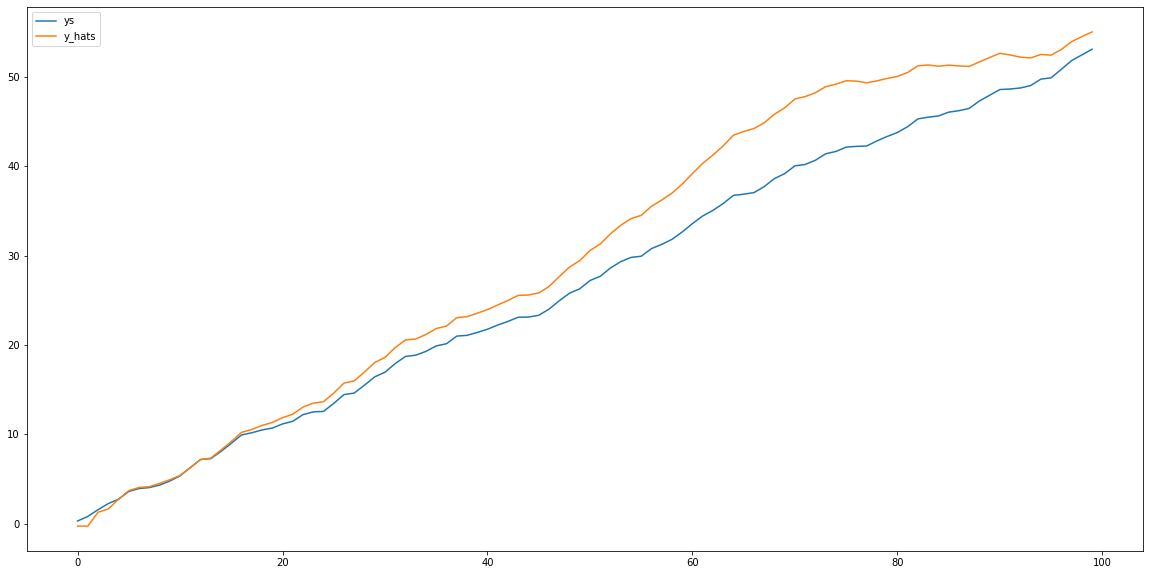

In [ ]:
results_df = pd.DataFrame({"ys": ys[:100], "y_hats":y_hats})
results_df.plot(y = ["ys", "y_hats"], figsize = (20,10))

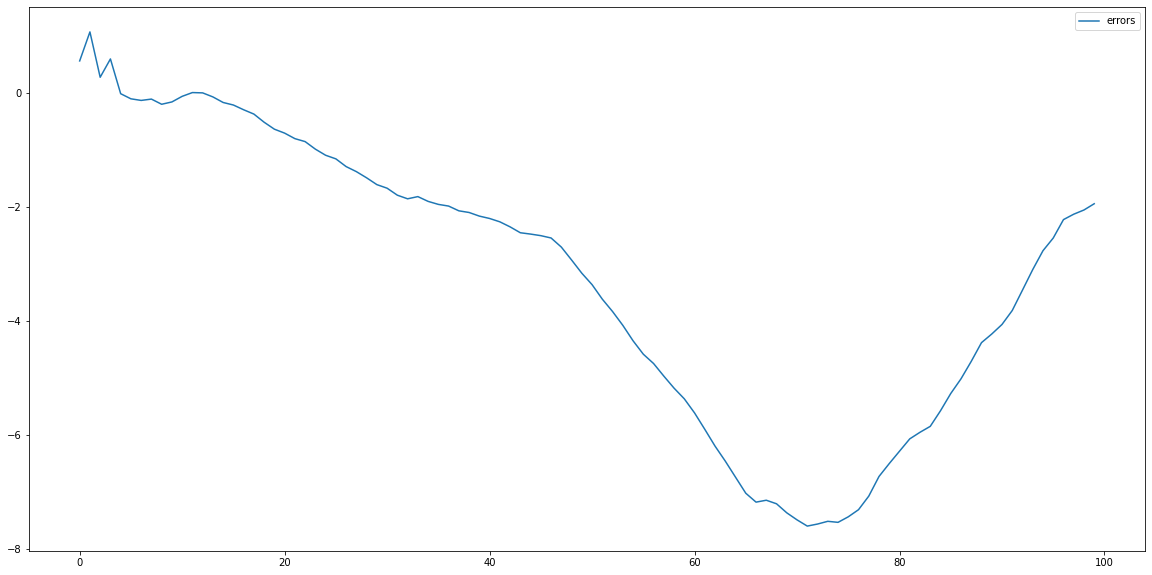

In [ ]:
results_df["errors"] =  results_df["ys"]- results_df["y_hats"]

results_df.plot(y = ["errors"], figsize = (20,10))

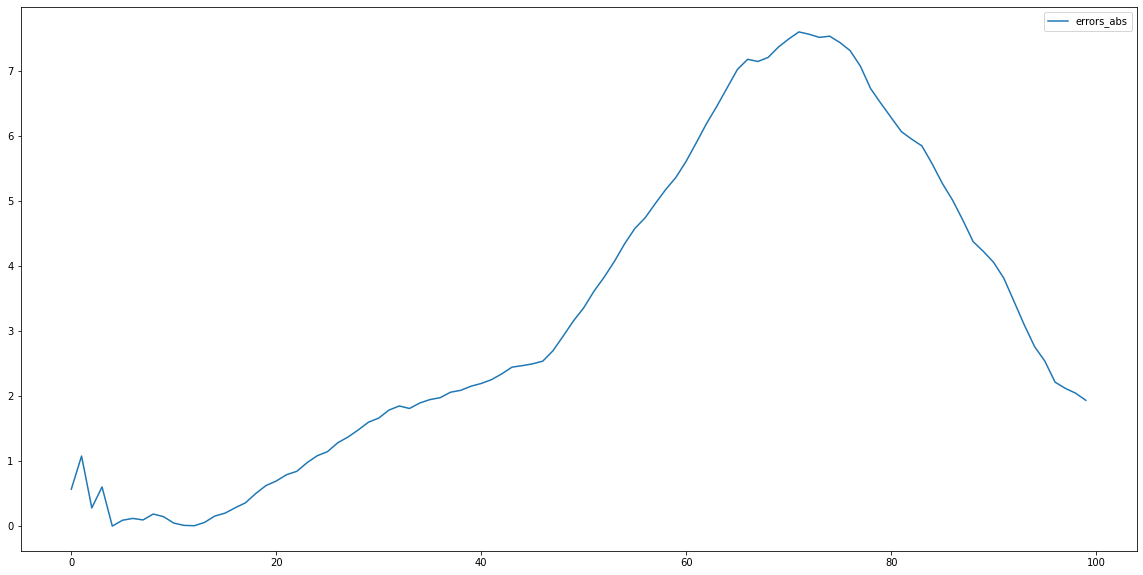

In [ ]:
results_df["errors_abs"] =  np.abs(results_df["errors"])
results_df.plot(y = ["errors_abs"], figsize = (20,10))